# Exercise 17.1 - Solution
## Speckle removal with denoising autoencoders (DAEs)
Small-angle scattering of X-rays or neutrons enables insights into properties of nanostructured materials.
In the case of X-rays from undulators at synchrotron radiation sources, extreme beam focusing can result in a high degree of coherence. Interference effects called speckles then appear naturally in the recorded data.
This may be an unwanted effect that makes the measurements appear noisy.  

Try to remove the speckles from the given test samples:
 1. Set up and train a deep convolutional autoencoder.
 2. State the test loss and comment on the reconstruction results for some test images.
 3. Apply the autoencoder to experimental data from partially coherent illumination and describe your observations.

Training DAEs on the provided data can be computationally demanding, thus, we recommend to use a GPU for this task.

In [13]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tensorflow import keras

layers = keras.layers



keras version 2.4.0


In [2]:
import gdown
import os
url = "https://drive.google.com/u/0/uc?export=download&confirm=HgGH&id=1CJVbIkLmzDTfC6ftaIUPiuqjoC0ay-wr"
output = 'speckles.npz'

if os.path.exists(output) == False:
    gdown.download(url, output, quiet=True)

### Preprocess data

In [3]:
f = np.load(output)
image_normal = f['target_images']
image_speckle = f['speckle_images']

# logarithmic intensity values
image_normal = np.log10(image_normal + 1.)                       
image_speckle = np.log10(image_speckle + 1.)

# norm input data to max. value of distorted scattering pattern
max_val = np.max(image_speckle, axis=(1, 2, 3), keepdims=True)

image_normal = image_normal / max_val
image_normal = np.clip(image_normal, 0., 1.1)  # limit maximum intensity values

image_speckle = image_speckle / max_val
image_speckle = np.clip(image_speckle, 0., 1.1)  # limit maximum intensity values

In [4]:
n_train = 20000
n = image_normal.shape[0]

x_train_noisy, x_test_noisy = image_speckle[0:n_train], image_speckle[n_train:]
x_train, x_test = image_normal[0:n_train], image_normal[n_train:]

### Plot example data 

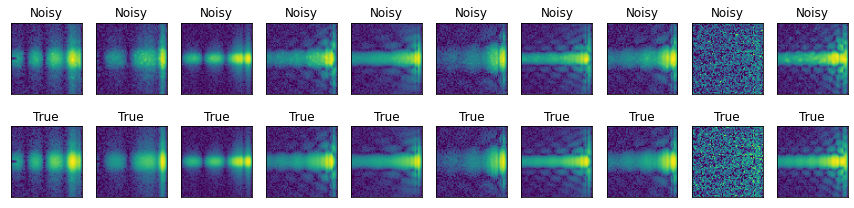

In [5]:
plots = 10
plt.figure(1, (15, 3.5))
idx = np.random.choice(n, 10)

for i in range(plots):
    plt.subplot(2, plots, i+1)
    plt.imshow(image_speckle[idx[i],:,:,0])
    plt.xticks([])
    plt.yticks([])
    plt.title("Noisy")

    plt.subplot(2, plots, plots+i+1)
    plt.imshow(image_normal[idx[i],:,:,0])
    plt.xticks([])
    plt.yticks([])
    plt.title("True")
    
plt.show()

## Model building

In [6]:
input_img = layers.Input(shape=(64, 64, 1))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(c1)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(c2)
encoded = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# decoder part
x = layers.UpSampling2D((2, 2))(encoded)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
c2_2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.Add()([c2, c2_2])             # shortcuts
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
c1_2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.Add()([c1, c1_2])             # shortcuts
x = layers.Conv2D(32, (3, 3), activation='linear', padding='same')(x)
decoded = layers.Conv2D(1, (3, 3), activation='linear', padding='same')(x)

autoencoder = keras.models.Model(input_img, decoded)

print(autoencoder.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

#### Plot model to visualize the shortcuts

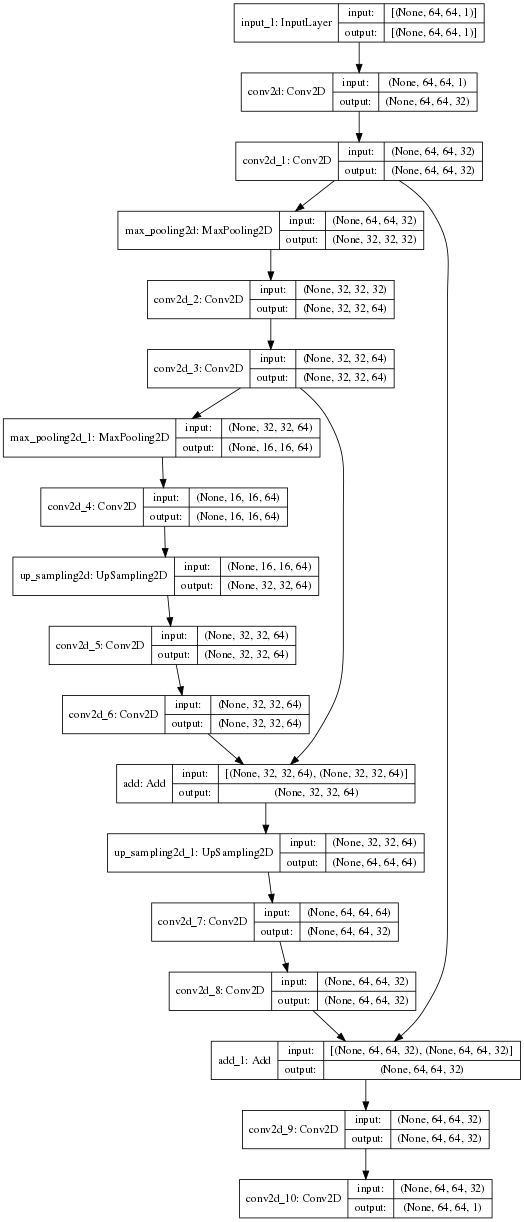

In [7]:
keras.utils.plot_model(autoencoder, show_shapes=True, dpi=60)

#### Compile and train the DAE

In [8]:
autoencoder.compile(optimizer=keras.optimizers.Adam(0.001), loss='mse')

earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)
rl_on_plateau = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.67, patience=2, verbose=1, min_lr=1e-5)

In [9]:
results = autoencoder.fit(x_train_noisy, x_train,
                          epochs=15,
                          batch_size=128,
                          validation_split=0.1,
                          verbose=1,
                          callbacks=[earlystopping, rl_on_plateau])

Epoch 1/15
141/141 [==============================] - 604s 4s/step - loss: 0.0172 - val_loss: 6.9266e-04
Epoch 2/15
141/141 [==============================] - 614s 4s/step - loss: 6.4259e-04 - val_loss: 5.7781e-04
Epoch 3/15
141/141 [==============================] - 601s 4s/step - loss: 5.5600e-04 - val_loss: 5.1935e-04
Epoch 4/15
141/141 [==============================] - 582s 4s/step - loss: 5.0566e-04 - val_loss: 4.9038e-04

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0006700000318232924.
Epoch 5/15
141/141 [==============================] - 613s 4s/step - loss: 4.6895e-04 - val_loss: 4.7533e-04
Epoch 6/15
141/141 [==============================] - 562s 4s/step - loss: 4.5965e-04 - val_loss: 4.6286e-04
Epoch 7/15
141/141 [==============================] - 550s 4s/step - loss: 4.5055e-04 - val_loss: 4.5379e-04

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0004489000252215192.
Epoch 8/15
141/141 [==============================] - 553s 4s/step - loss: 4.38

### Plot training history

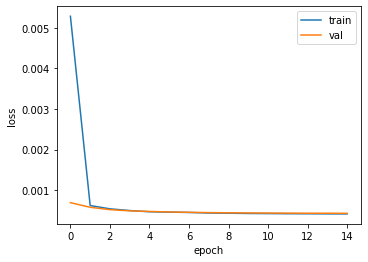

In [10]:
plt.figure(1, (12, 4))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

### Investigate the DAE performance using the test data

In [11]:
preds = autoencoder.predict(x_test_noisy, verbose=1)

172/172 [==============================] - 33s 191ms/step


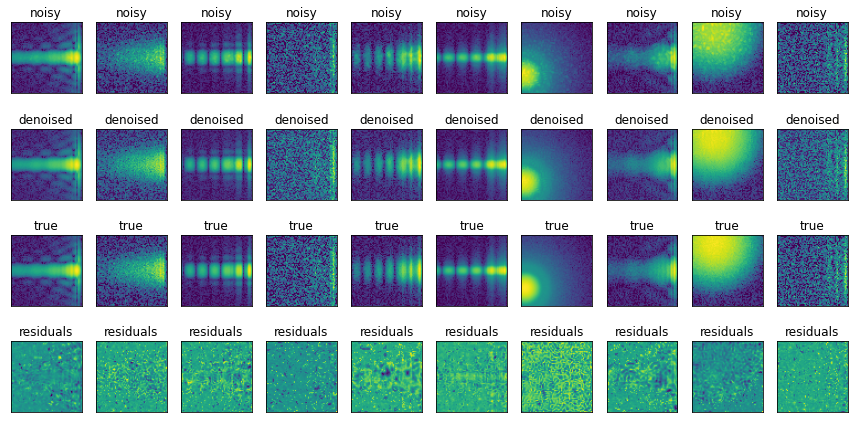

In [14]:
plots = 10
n_test = x_test.shape[0]
plt.figure(1, (15, 7.5))
idx = np.random.choice(n_test, 10)

for i in range(plots):
    plt.subplot(4, plots, i+1)
    plt.imshow(x_test_noisy[idx[i],:,:,0])
    plt.xticks([])
    plt.yticks([])
    plt.title("noisy")

    plt.subplot(4, plots, plots+i+1)
    plt.imshow(preds[idx[i],:,:,0])
    plt.xticks([])
    plt.yticks([])
    plt.title("denoised")

    plt.subplot(4, plots, 2*plots+i+1)
    plt.imshow(x_test[idx[i],:,:,0])
    plt.xticks([])
    plt.yticks([])
    plt.title("true")
    
    plt.subplot(4, plots, 3*plots+i+1)
    plt.imshow(x_test[idx[i],:,:,0] - preds[idx[i],:,:,0])
    plt.xticks([])
    plt.yticks([])
    plt.title("residuals")

plt.show()